In [ ]:
# ------------------ CONFIG ------------------
import os
import random
import pandas as pd
import pydicom
from PIL import Image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
%matplotlib inline
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from shapely.geometry import box as shapely_box
import os
import cv2
import csv
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# ------------------ IMPORTS ------------------
import os
import random
import pandas as pd
import numpy as np
import pydicom
from PIL import Image
from tqdm import tqdm
import albumentations as A
from ultralytics import YOLO

# ------------------ CONFIG ------------------
csv_path = '/Users/hilaryhenshaw/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
dcm_dir = '/Users/hilaryhenshaw/Downloads/rsna-pneumonia-detection-challenge/stage_2_train_images'
output_base = '/Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset'
split_ratio = (0.7, 0.15, 0.15)
image_ext = ".jpg"
sample_size = 3000  # Increased sample size
random.seed(31415)

# ------------------ AUGMENTATION SETUP ------------------
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=10, p=0.3),
    A.GaussNoise(p=0.2)
])

# ------------------ DIRECTORY SETUP ------------------
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_base, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(output_base, 'labels', split), exist_ok=True)

# ------------------ LOAD AND BALANCE ------------------
df = pd.read_csv(csv_path)
df_pos = df[df['Target'] == 1]
df_neg = df[df['Target'] == 0]

pos_ids = df_pos['patientId'].unique()
neg_ids = df_neg['patientId'].unique()
balanced_neg_ids = random.sample(list(neg_ids), len(pos_ids))
balanced_ids = list(pos_ids) + balanced_neg_ids
random.shuffle(balanced_ids)
sampled_ids = balanced_ids[:sample_size]

# ------------------ SPLIT ------------------
n_total = len(sampled_ids)
n_train = int(split_ratio[0] * n_total)
n_val = int(split_ratio[1] * n_total)

train_ids = sampled_ids[:n_train]
val_ids = sampled_ids[n_train:n_train + n_val]
test_ids = sampled_ids[n_train + n_val:]

split_map = {pid: 'train' for pid in train_ids}
split_map.update({pid: 'val' for pid in val_ids})
split_map.update({pid: 'test' for pid in test_ids})

grouped = df.groupby('patientId')

# ------------------ PROCESS IMAGES AND LABELS ------------------
for patient_id in tqdm(sampled_ids, desc="Processing images and labels"):
    if patient_id not in split_map:
        continue

    split = split_map[patient_id]
    dcm_path = os.path.join(dcm_dir, f"{patient_id}.dcm")

    try:
        dcm = pydicom.dcmread(dcm_path)
        img = dcm.pixel_array
        height, width = img.shape
    except Exception as e:
        print(f"Skipping {patient_id}: {e}") 
        continue

    # Normalize and augment image
    img_norm = (img - img.min()) / (img.max() - img.min()) * 255.0
    img_uint8 = img_norm.astype('uint8')
    augmented = augmentor(image=img_uint8)['image']
    img_pil = Image.fromarray(augmented)
    img_save_path = os.path.join(output_base, 'images', split, f"{patient_id}{image_ext}")
    img_pil.save(img_save_path)

    # Save label
    label_lines = []
    patient_rows = grouped.get_group(patient_id)
    for _, row in patient_rows.iterrows():
        if row['Target'] == 0:
            continue
        x, y, w, h = row['x'], row['y'], row['width'], row['height']
        if w <= 0 or h <= 0:
            continue  # Skip invalid boxes
        x_center = (x + w / 2) / width
        y_center = (y + h / 2) / height
        w_norm = w / width
        h_norm = h / height
        label_lines.append(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")

    label_path = os.path.join(output_base, 'labels', split, f"{patient_id}.txt")
    with open(label_path, "w") as f:
        f.write("\n".join(label_lines))

# ------------------ YAML CONFIG ------------------
yaml_path = os.path.join(output_base, "rsna.yaml")
with open(yaml_path, "w") as f:
    f.write(f"""\
train: {os.path.abspath(output_base)}/images/train
val: {os.path.abspath(output_base)}/images/val
test: {os.path.abspath(output_base)}/images/test

nc: 1
names: ['pneumonia']
""")

# ------------------ TRAIN ------------------
model = YOLO('yolov8m.pt')  # Medium model for balance of speed and accuracy
results = model.train(
    data=yaml_path,
    epochs=100,  # Increased training duration
    imgsz=640,
    batch=8,
    name='rsna_yolov8_augmented',
    project=os.path.join(output_base, 'YOLO_runs'),
    val=True,
    augment=True,  # YOLOv8 built-in augmentation
    patience=10
)

# ------------------ EVALUATE ------------------
model = YOLO(os.path.join(output_base, 'YOLO_runs/rsna_yolov8_augmented/weights/best.pt'))
metrics = model.val(
    data=yaml_path,
    split='test',
    project=os.path.join(output_base, 'YOLO_eval'),
    name='rsna_eval'
)


Processing images and labels: 100%|██████████| 3000/3000 [00:56<00:00, 53.39it/s]


New https://pypi.org/project/ultralytics/8.3.179 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.175 🚀 Python-3.13.1 torch-2.8.0 CPU (Apple M2 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/rsna.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, 

train: Scanning /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/labels/train... 2100 images, 1053 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:00<00:00, 2789.70it/s]

train: New cache created: /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 549.7±603.1 MB/s, size: 69.1 KB)



val: Scanning /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/labels/val... 600 images, 297 backgrounds, 0 corrupt: 100%|██████████| 600/600 [00:00<00:00, 3582.56it/s]

val: New cache created: /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/labels/val.cache


Plotting labels to /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/YOLO_runs/rsna_yolov8_augmented8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/YOLO_runs/rsna_yolov8_augmented8
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      2.664      3.892      2.598          2        640: 100%|██████████| 263/263 [36:56<00:00,  8.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [10:01<00:00, 15.82s/it]

                   all        600        487    0.00141      0.037   0.000993   0.000332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      2.671      3.808      2.598          6        640: 100%|██████████| 263/263 [38:16<00:00,  8.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [10:11<00:00, 16.09s/it]

                   all        600        487    0.00136      0.353    0.00164   0.000434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      2.653      3.777      2.563         11        640: 100%|██████████| 263/263 [33:50<00:00,  7.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:52<00:00, 15.58s/it]

                   all        600        487    0.00208       0.76    0.00684    0.00166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      2.557      3.695      2.524          4        640: 100%|██████████| 263/263 [35:12<00:00,  8.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:45<00:00, 15.40s/it]

                   all        600        487    0.00478      0.749      0.021    0.00542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      2.552      3.583      2.505         10        640: 100%|██████████| 263/263 [35:11<00:00,  8.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:39<00:00, 15.24s/it]

                   all        600        487    0.00234      0.828     0.0182    0.00453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      2.503      3.526      2.464          3        640: 100%|██████████| 263/263 [35:00<00:00,  7.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:42<00:00, 15.32s/it]

                   all        600        487    0.00331      0.858     0.0268    0.00648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      2.442      3.498       2.38          3        640: 100%|██████████| 263/263 [35:22<00:00,  8.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:42<00:00, 15.32s/it]

                   all        600        487    0.00395      0.838     0.0233    0.00599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      2.444      3.441       2.36          4        640: 100%|██████████| 263/263 [31:48<00:00,  7.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:46<00:00, 15.43s/it]

                   all        600        487     0.0381      0.263     0.0486     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      2.408      3.408      2.357          6        640: 100%|██████████| 263/263 [35:00<00:00,  7.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:43<00:00, 15.35s/it]

                   all        600        487     0.0039      0.891     0.0579     0.0158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G        2.4      3.418      2.393          3        640: 100%|██████████| 263/263 [35:14<00:00,  8.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:45<00:00, 15.41s/it]

                   all        600        487    0.00515      0.867     0.0636      0.017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      2.359      3.431      2.332          6        640: 100%|██████████| 263/263 [34:51<00:00,  7.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:51<00:00, 15.56s/it]

                   all        600        487    0.00388      0.889     0.0542     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      2.347      3.356      2.345         15        640: 100%|██████████| 263/263 [34:50<00:00,  7.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:52<00:00, 15.58s/it]

                   all        600        487     0.0053      0.848     0.0442     0.0115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      2.332      3.377      2.308          3        640: 100%|██████████| 263/263 [32:02<00:00,  7.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:47<00:00, 15.45s/it]

                   all        600        487    0.00748      0.774     0.0562     0.0171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      2.331      3.339      2.308          3        640: 100%|██████████| 263/263 [35:05<00:00,  8.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:45<00:00, 15.41s/it]

                   all        600        487    0.00748      0.805     0.0549     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      2.348      3.314       2.26          1        640: 100%|██████████| 263/263 [35:20<00:00,  8.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:52<00:00, 15.59s/it]

                   all        600        487    0.00477      0.854     0.0582     0.0179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      2.312      3.283      2.282          5        640: 100%|██████████| 263/263 [35:21<00:00,  8.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:45<00:00, 15.41s/it]

                   all        600        487    0.00537      0.854     0.0654     0.0183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      2.315      3.283      2.264          3        640: 100%|██████████| 263/263 [33:14<00:00,  7.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [08:31<00:00, 13.45s/it]

                   all        600        487     0.0115       0.77     0.0683     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      2.325      3.278      2.246          6        640: 100%|██████████| 263/263 [30:14<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:10<00:00, 14.48s/it]

                   all        600        487     0.0302      0.536     0.0801     0.0198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      2.285      3.235      2.227          6        640: 100%|██████████| 263/263 [39:22<00:00,  8.98s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:52<00:00, 15.59s/it]

                   all        600        487      0.031      0.458     0.0731     0.0186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      2.296      3.277      2.237         13        640: 100%|██████████| 263/263 [36:49<00:00,  8.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:58<00:00, 15.75s/it]

                   all        600        487      0.034       0.45     0.0614     0.0172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      2.261      3.232      2.217          8        640: 100%|██████████| 263/263 [34:09<00:00,  7.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [08:35<00:00, 13.56s/it]

                   all        600        487     0.0191      0.667     0.0799     0.0227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G       2.25      3.192      2.209          3        640: 100%|██████████| 263/263 [32:55<00:00,  7.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [08:30<00:00, 13.43s/it]

                   all        600        487    0.00384      0.891     0.0804     0.0231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      2.252      3.195      2.236         10        640: 100%|██████████| 263/263 [32:46<00:00,  7.48s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [10:28<00:00, 16.54s/it]

                   all        600        487     0.0369      0.571      0.116     0.0342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      2.218      3.182      2.194          7        640: 100%|██████████| 263/263 [35:37<00:00,  8.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:41<00:00, 15.30s/it]

                   all        600        487     0.0502      0.454     0.0873     0.0241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G       2.21      3.183       2.21          6        640: 100%|██████████| 263/263 [35:08<00:00,  8.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:43<00:00, 15.36s/it]

                   all        600        487      0.147      0.214      0.103      0.032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G       2.22      3.204      2.199          3        640: 100%|██████████| 263/263 [35:30<00:00,  8.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:53<00:00, 15.62s/it]

                   all        600        487     0.0998      0.369      0.119     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G        2.2      3.187      2.183          4        640: 100%|██████████| 263/263 [35:53<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:01<00:00, 14.24s/it]

                   all        600        487     0.0418      0.528       0.11     0.0337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      2.201      3.216      2.187          7        640: 100%|██████████| 263/263 [35:59<00:00,  8.21s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [10:42<00:00, 16.91s/it]

                   all        600        487      0.189      0.246      0.123     0.0336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      2.181      3.197      2.177          1        640: 100%|██████████| 263/263 [58:50<00:00, 13.42s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [14:13<00:00, 22.47s/it]

                   all        600        487      0.192      0.172     0.0978     0.0304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      2.165      3.155       2.19          6        640: 100%|██████████| 263/263 [36:47<00:00,  8.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [10:27<00:00, 16.52s/it]

                   all        600        487     0.0877      0.359      0.102     0.0274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      2.214      3.161        2.2          7        640: 100%|██████████| 263/263 [36:49<00:00,  8.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:51<00:00, 15.55s/it]

                   all        600        487     0.0694      0.446      0.122     0.0294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      2.144       3.14      2.165          7        640: 100%|██████████| 263/263 [34:51<00:00,  7.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:51<00:00, 15.55s/it]

                   all        600        487      0.248       0.16      0.112     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      2.156      3.146      2.153          7        640: 100%|██████████| 263/263 [35:07<00:00,  8.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [10:32<00:00, 16.64s/it]

                   all        600        487      0.165      0.195     0.0934     0.0292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      2.189      3.137      2.174          5        640: 100%|██████████| 263/263 [34:21<00:00,  7.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:06<00:00, 14.39s/it]

                   all        600        487       0.24      0.123      0.112     0.0309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      2.159      3.089       2.14          9        640: 100%|██████████| 263/263 [32:45<00:00,  7.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [08:46<00:00, 13.87s/it]

                   all        600        487      0.196      0.226      0.118     0.0344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      2.154      3.113      2.171          8        640: 100%|██████████| 263/263 [31:04<00:00,  7.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [08:49<00:00, 13.94s/it]

                   all        600        487      0.253      0.177      0.123     0.0374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      2.129      3.098      2.128          9        640: 100%|██████████| 263/263 [41:15<00:00,  9.41s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:49<00:00, 15.52s/it]

                   all        600        487      0.308      0.125       0.12     0.0319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      2.123      3.125      2.141          3        640: 100%|██████████| 263/263 [35:02<00:00,  7.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [10:10<00:00, 16.06s/it]

                   all        600        487      0.216       0.14      0.102      0.032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G       2.14      3.168      2.135          3        640: 100%|██████████| 263/263 [32:53<00:00,  7.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:49<00:00, 15.50s/it]

                   all        600        487       0.21      0.166      0.107     0.0357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      2.132      3.036      2.126          4        640: 100%|██████████| 263/263 [34:58<00:00,  7.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:53<00:00, 15.62s/it]

                   all        600        487      0.225       0.17      0.106     0.0346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G       2.11      3.049      2.102          9        640: 100%|██████████| 263/263 [35:08<00:00,  8.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:42<00:00, 15.34s/it]

                   all        600        487      0.214      0.177       0.11      0.033



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      2.095      3.044      2.138          5        640: 100%|██████████| 263/263 [35:15<00:00,  8.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:42<00:00, 15.34s/it]

                   all        600        487       0.26      0.185      0.117      0.036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G        2.1      3.105      2.134          1        640: 100%|██████████| 263/263 [35:26<00:00,  8.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:50<00:00, 15.53s/it]

                   all        600        487      0.263      0.181      0.138     0.0415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      2.125      3.119      2.147          0        640: 100%|██████████| 263/263 [32:11<00:00,  7.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:43<00:00, 15.35s/it]

                   all        600        487      0.206      0.183      0.115     0.0358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      2.109      3.059       2.12          5        640: 100%|██████████| 263/263 [35:11<00:00,  8.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:42<00:00, 15.34s/it]

                   all        600        487      0.165      0.164        0.1     0.0321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      2.117      3.051      2.139          8        640: 100%|██████████| 263/263 [35:17<00:00,  8.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:50<00:00, 15.54s/it]

                   all        600        487      0.251      0.174      0.127     0.0384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      2.081      3.025      2.097          6        640: 100%|██████████| 263/263 [35:44<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:39<00:00, 15.26s/it]

                   all        600        487      0.241       0.17      0.121     0.0399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      2.106      3.024      2.096          5        640: 100%|██████████| 263/263 [35:08<00:00,  8.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:48<00:00, 15.48s/it]

                   all        600        487       0.21      0.185      0.115     0.0358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      2.071      2.993      2.081          6        640: 100%|██████████| 263/263 [31:29<00:00,  7.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:55<00:00, 15.68s/it]


                   all        600        487      0.253      0.154      0.112     0.0343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      2.093      3.026      2.116          3        640: 100%|██████████| 263/263 [35:08<00:00,  8.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [09:56<00:00, 15.69s/it]

                   all        600        487      0.225      0.172      0.119     0.0354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G       2.08      2.954      2.083          9        640: 100%|██████████| 263/263 [7:04:43<00:00, 96.90s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [1:50:17<00:00, 174.14s/it]  

                   all        600        487      0.237      0.205      0.129     0.0382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      2.079      3.003        2.1          7        640: 100%|██████████| 263/263 [37:15<00:00,  8.50s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [08:57<00:00, 14.14s/it]

                   all        600        487      0.228      0.199      0.136     0.0414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      2.069      2.964      2.102          6        640: 100%|██████████| 263/263 [38:27<00:00,  8.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [10:31<00:00, 16.63s/it]

                   all        600        487      0.309      0.113      0.129     0.0383
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 43, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



53 epochs completed in 48.160 hours.
Optimizer stripped from /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/YOLO_runs/rsna_yolov8_augmented8/weights/last.pt, 52.0MB
Optimizer stripped from /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/YOLO_runs/rsna_yolov8_augmented8/weights/best.pt, 52.0MB

Validating /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/YOLO_runs/rsna_yolov8_augmented8/weights/best.pt...
Ultralytics 8.3.175 🚀 Python-3.13.1 torch-2.8.0 CPU (Apple M2 Pro)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [24:01<00:00, 37.93s/it]


                   all        600        487      0.233      0.302      0.168     0.0483
Speed: 1.0ms preprocess, 2390.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/YOLO_runs/rsna_yolov8_augmented8
Ultralytics 8.3.175 🚀 Python-3.13.1 torch-2.8.0 CPU (Apple M2 Pro)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 167.7±56.4 MB/s, size: 54.5 KB)


val: Scanning /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/labels/test... 602 images, 299 backgrounds, 0 corrupt: 100%|██████████| 602/602 [00:00<00:00, 2790.24it/s]

val: New cache created: /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [08:46<00:00, 13.85s/it]


                   all        602        475    0.00438      0.623     0.0147    0.00372
Speed: 0.8ms preprocess, 866.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/YOLO_eval/rsna_eval7


In [ ]:
# ------------------ Save Original Image ------------------
img_norm = (img - img.min()) / (img.max() - img.min()) * 255.0
img_uint8 = img_norm.astype('uint8')
img_pil = Image.fromarray(img_uint8)
img_save_path = os.path.join(output_base, 'images', split, f"{patient_id}{image_ext}")
img_pil.save(img_save_path)

# ------------------ Check if Pneumonia ------------------
is_pneumonia = any(row['Target'] == 1 for _, row in grouped.get_group(patient_id).iterrows())

# ------------------ Apply Augmentation Only to Pneumonia Cases ------------------
augmented_count = 0
visualize_aug = False  # Set to True to see side-by-side plots

if is_pneumonia:
    for i in range(2):  # Create 2 augmented versions
        aug_id = f"{patient_id}_aug{i}"
        aug_img_path = os.path.join(output_base, 'images', split, f"{aug_id}{image_ext}")
        aug_label_path = os.path.join(output_base, 'labels', split, f"{aug_id}.txt")

        # Skip if already exists
        if os.path.exists(aug_img_path) and os.path.exists(aug_label_path):
            continue

        # Apply augmentation
        augmented = augmentor(image=img_uint8)
        aug_img = Image.fromarray(augmented['image'])
        aug_img.save(aug_img_path)

        # Copy label file
        label_path = os.path.join(output_base, 'labels', split, f"{patient_id}.txt")
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label_data = f.read()
            with open(aug_label_path, "w") as f:
                f.write(label_data)

        augmented_count += 1

        # Optional: visualize original vs. augmented
        if visualize_aug and i == 0:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(img_uint8, cmap='gray')
            plt.title('Original')
            plt.subplot(1, 2, 2)
            plt.imshow(augmented['image'], cmap='gray')
            plt.title('Augmented')
            plt.show()

# ------------------ Log Augmentation Summary ------------------
if idx == len(sampled_ids) - 1:  # After last image
    print(f"\n Total augmented pneumonia samples added: {augmented_count}")




✅ Total augmented pneumonia samples added: 0


Number of IoU scores: 22
IoU values: [1.0, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.0, 0.5, 1.0, 0.0, 0.5, 1.0, 1.0, 0.5, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]


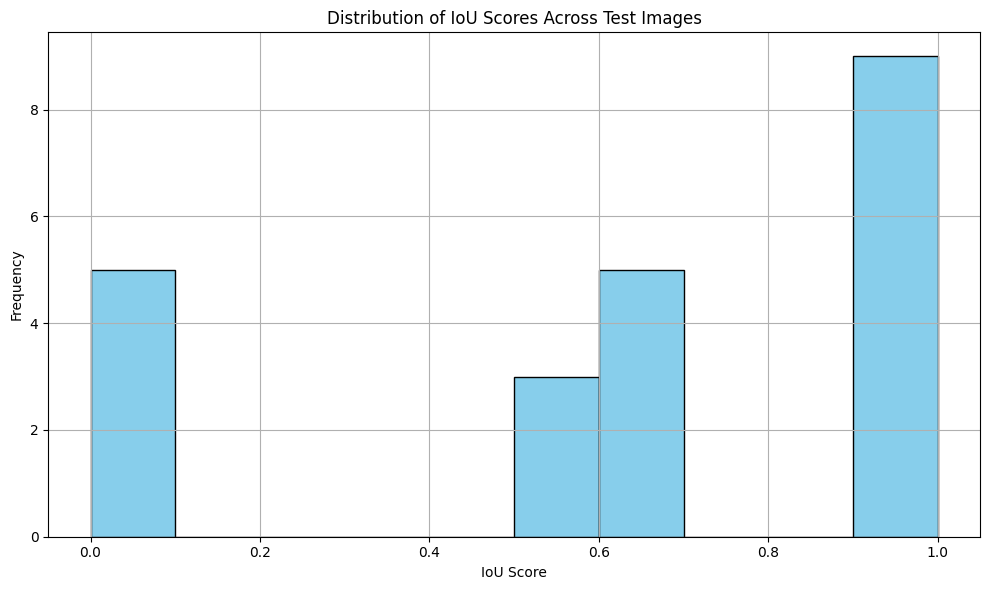

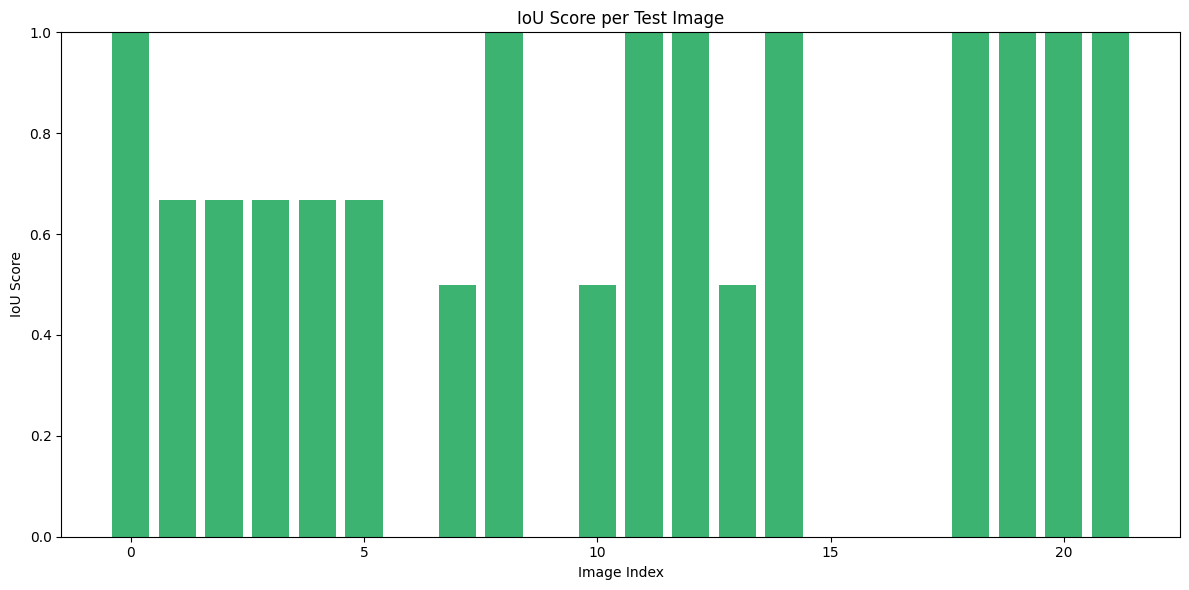

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import csv

# Path to your saved IoU stats
csv_path = '/Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/YOLO_eval/detection_stats.csv'

# Load IoU values from previous evaluation
ious = []
with open(csv_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)  # skip header
    for row in reader:
        tp, fp, fn = int(row[1]), int(row[2]), int(row[3])
        if tp + fp + fn > 0:
            iou = tp / (tp + fp + fn)
            ious.append(iou)

print(f"Number of IoU scores: {len(ious)}")
print("IoU values:", ious)

# ------------------ Plot IoU Histogram ------------------
plt.figure(figsize=(10, 6))
plt.hist(ious, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of IoU Scores Across Test Images')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------ Plot IoU Bar Chart ------------------
plt.figure(figsize=(12, 6))
plt.bar(range(len(ious)), ious, color='mediumseagreen')
plt.title('IoU Score per Test Image')
plt.xlabel('Image Index')
plt.ylabel('IoU Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Ultralytics 8.3.175 🚀 Python-3.13.1 torch-2.8.0 CPU (Apple M2 Pro)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 237.2±237.9 MB/s, size: 161.5 KB)


val: Scanning /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/labels/test.cache... 1066 images, 299 backgrounds, 0 corrupt: 100%|██████████| 1066/1066 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [03:46<00:00,  3.38s/it]


                   all       1066       1197      0.225        0.3      0.144     0.0461
Speed: 0.8ms preprocess, 203.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /Users/hilaryhenshaw/Desktop/MS Data Science/DSP 566 - Advanced Machine Learning/final project/rsna_yolo_subset/YOLO_eval/rsna_eval229

0: 640x640 (no detections), 146.2ms
1: 640x640 2 pneumonias, 146.2ms
2: 640x640 3 pneumonias, 146.2ms
3: 640x640 3 pneumonias, 146.2ms
4: 640x640 3 pneumonias, 146.2ms
5: 640x640 3 pneumonias, 146.2ms
6: 640x640 3 pneumonias, 146.2ms
7: 640x640 2 pneumonias, 146.2ms
8: 640x640 2 pneumonias, 146.2ms
9: 640x640 1 pneumonia, 146.2ms
10: 640x640 (no detections), 146.2ms
11: 640x640 4 pneumonias, 146.2ms
12: 640x640 (no detections), 146.2ms
13: 640x640 2 pneumonias, 146.2ms
14: 640x640 2 pneumonias, 146.2ms
15: 640x640 1 pneumonia, 146.2ms
16: 640x640 1 pneumonia, 146.2ms
17: 640x640 1 pneumonia, 146.2ms
18: 640x640 (no detections), 146.2ms
19: 640x640 (no detections), 1

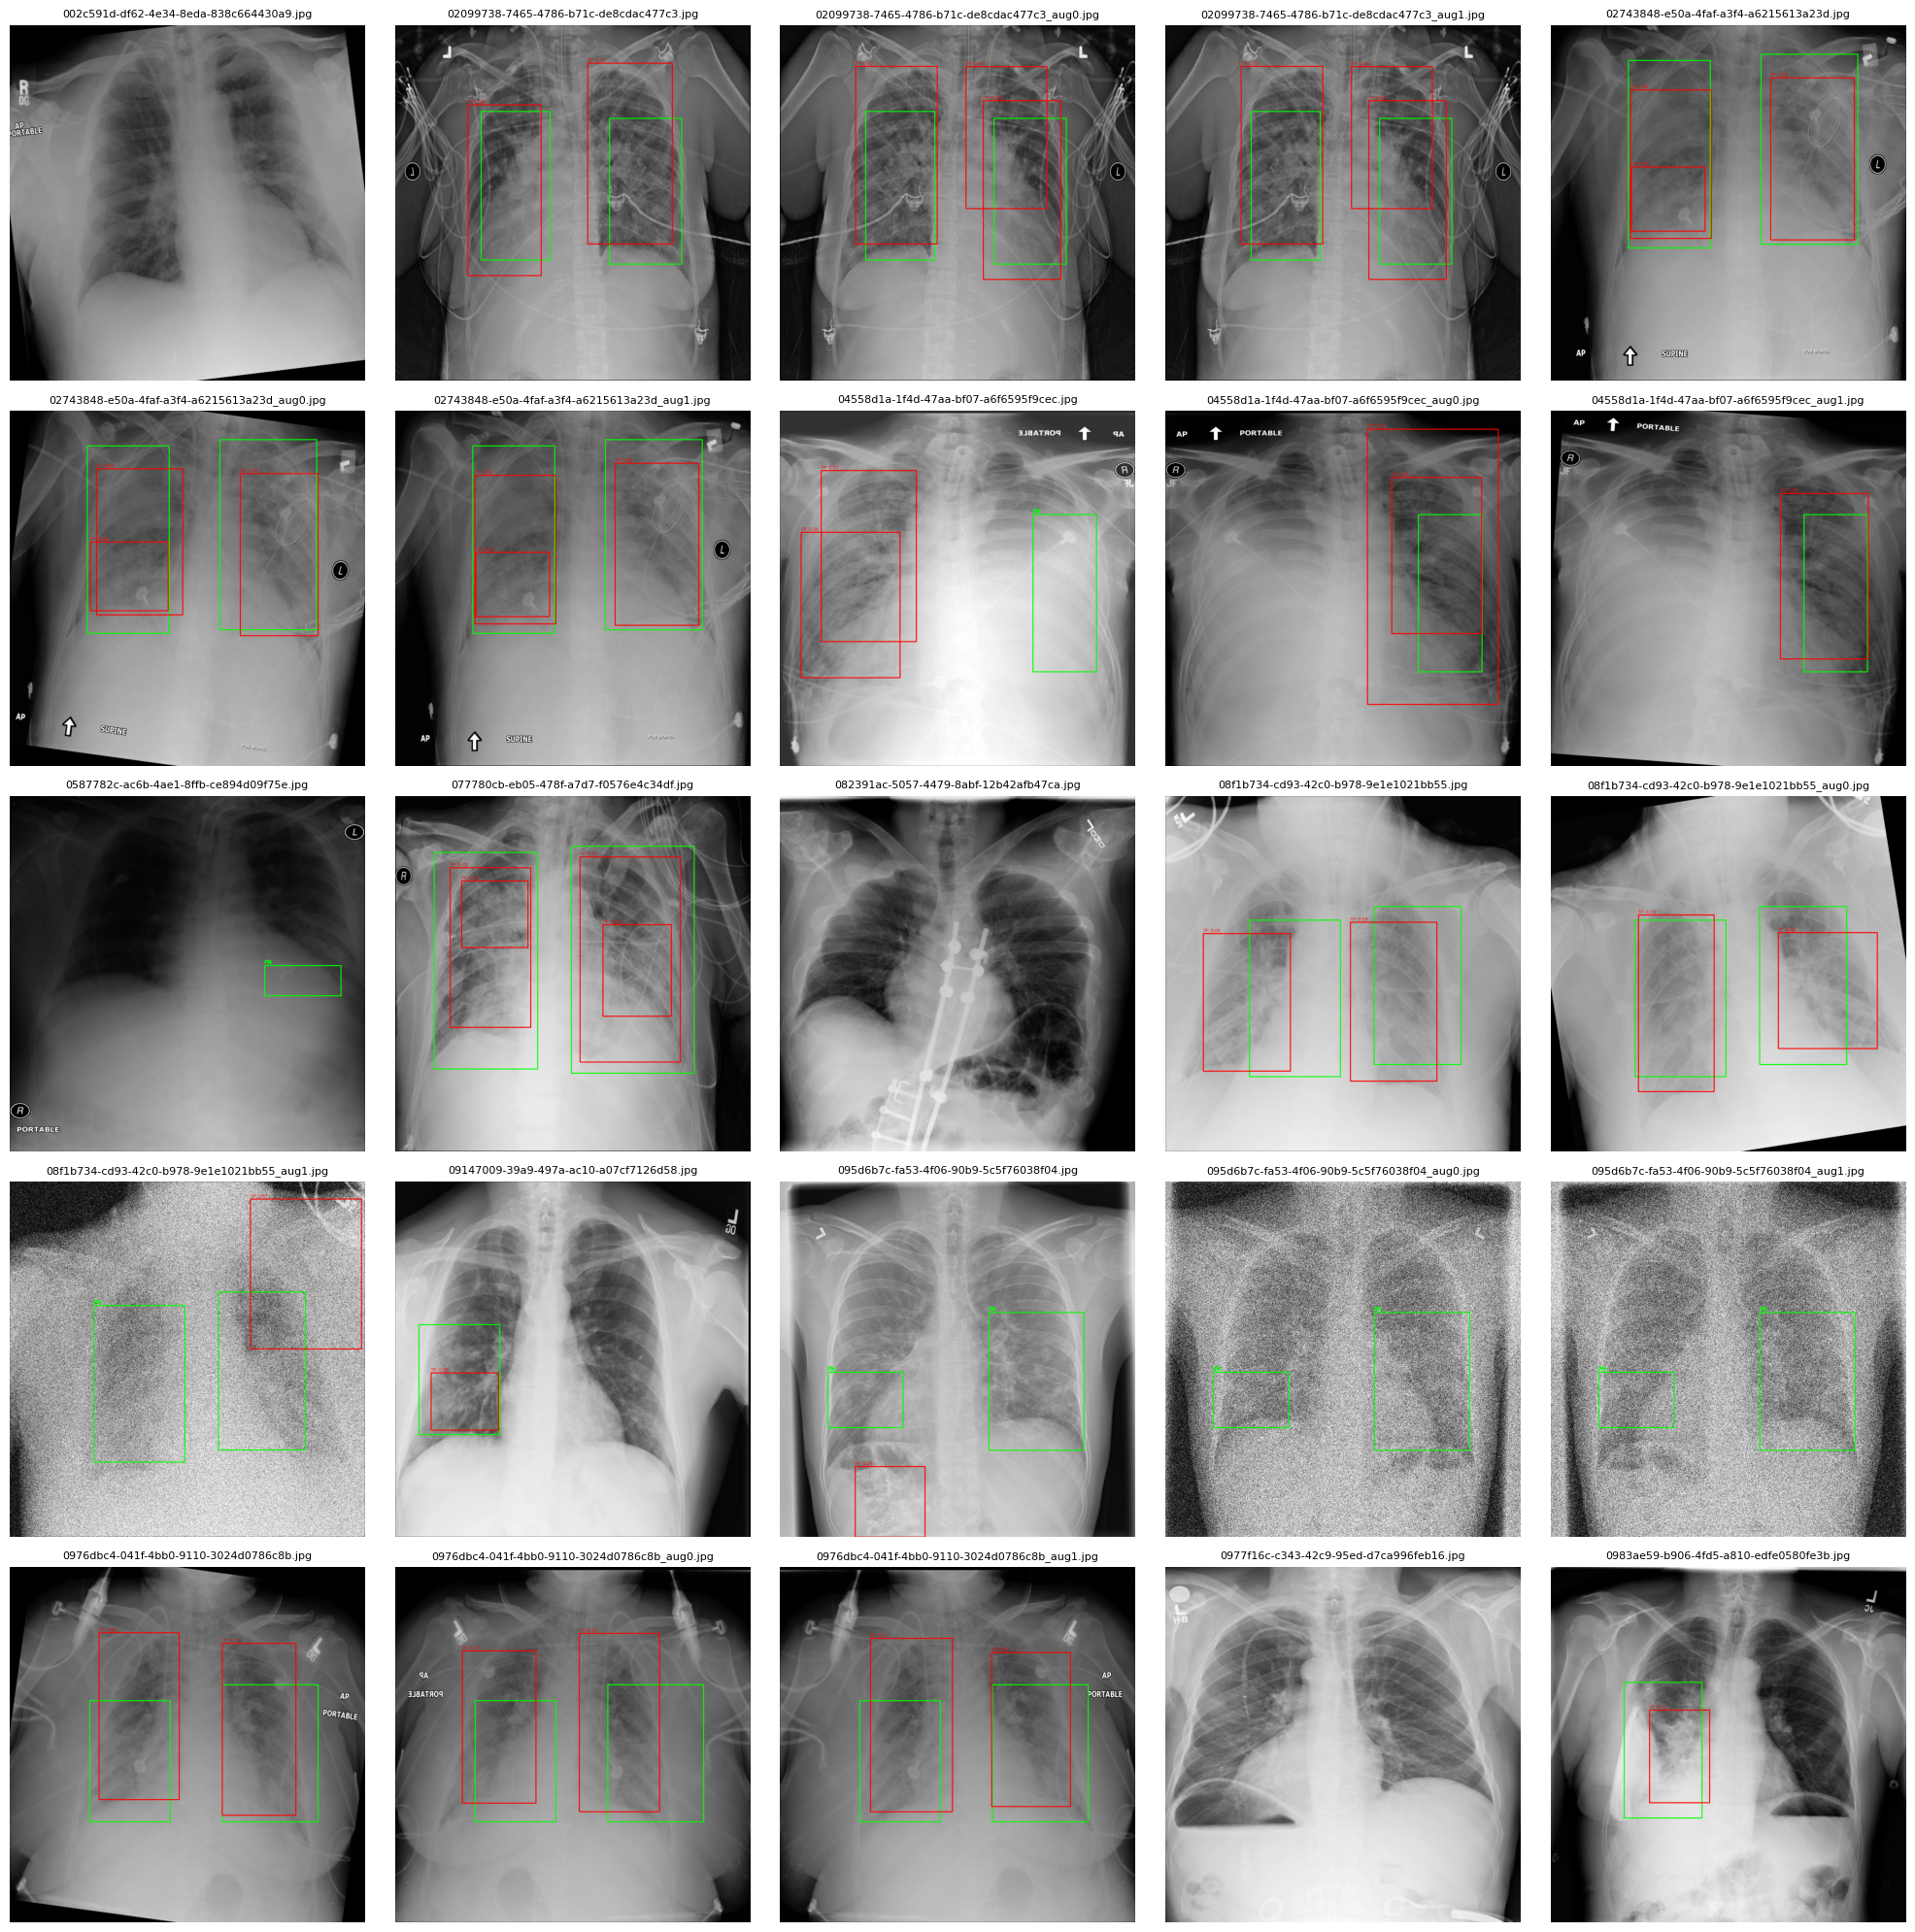

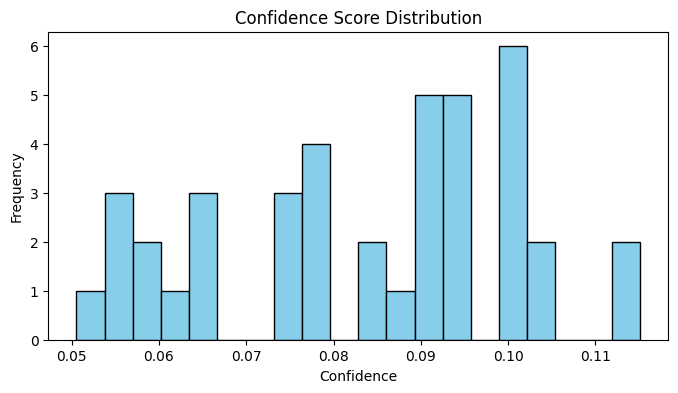

In [ ]:
# ------------------ Load Trained Model ------------------
model_path = os.path.join(output_base, 'YOLO_runs/rsna_yolov8/weights/best.pt')
model = YOLO(model_path)

# ------------------ Run Evaluation ------------------
metrics = model.val(
    data=yaml_path,
    split='test',
    project=os.path.join(output_base, 'YOLO_eval'),
    name='rsna_eval2'
)

# ------------------ Get Test Images ------------------
test_image_dir = os.path.join(output_base, 'images/test')
test_label_dir = os.path.join(output_base, 'labels/test')

image_files = sorted([f for f in os.listdir(test_image_dir) if f.endswith('.jpg')])[:25]
img_paths = [os.path.join(test_image_dir, f) for f in image_files]

# ------------------ Configurable Confidence Threshold ------------------
conf_threshold = 0.05
results = model(img_paths, conf=conf_threshold, iou=0.4, max_det=10)

# ------------------ Setup Plot ------------------
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten()

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea) if (boxAArea + boxBArea - interArea) > 0 else 0
    return iou

iou_threshold = 0.01
total_tp = 0
total_fp = 0
total_fn = 0
confidences = []


# ------------------ CSV Setup ------------------
csv_path = os.path.join(output_base, 'YOLO_eval', 'detection_stats.csv')
with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Image', 'True Positives', 'False Positives', 'False Negatives'])

    for idx, (img_file, result, ax) in enumerate(zip(image_files, results, axs)):
        img_path = os.path.join(test_image_dir, img_file)
        label_path = os.path.join(test_label_dir, img_file.replace('.jpg', '.txt'))

        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read {img_path}")
            continue
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        gt_boxes = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        _, x_c, y_c, bw, bh = map(float, parts)
                        x1 = int((x_c - bw / 2) * w)
                        y1 = int((y_c - bh / 2) * h)
                        x2 = int((x_c + bw / 2) * w)
                        y2 = int((y_c + bh / 2) * h)
                        gt_boxes.append((x1, y1, x2, y2))

        pred_boxes = []
        pred_info = []
        if result.boxes:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = float(box.conf[0])
                cls = int(box.cls[0])
                # Optional: filter out tiny boxes (e.g., < 10x10 pixels)
                if (x2 - x1) * (y2 - y1) < 100:  # adjust threshold if needed
                    continue
                pred_boxes.append((x1, y1, x2, y2))
                pred_info.append((x1, y1, x2, y2, conf, cls))
                confidences.append(conf)

        matched_gt = set()
        matched_pred = set()

        for i, gt in enumerate(gt_boxes):
            for j, pred in enumerate(pred_boxes):
                iou = compute_iou(gt, pred)
                if iou >= iou_threshold:
                    matched_gt.add(i)
                    matched_pred.add(j)
                    x1, y1, x2, y2 = gt
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    x1p, y1p, x2p, y2p, conf, cls = pred_info[j]
                    cv2.rectangle(img, (x1p, y1p), (x2p, y2p), (255, 0, 0), 2)
                    cv2.putText(img, f"TP {conf:.2f}", (x1p, max(10, y1p - 5)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
                    break

        for i, gt in enumerate(gt_boxes):
            if i not in matched_gt:
                x1, y1, x2, y2 = gt
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, "FN", (x1, max(10, y1 - 5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        for j, pred in enumerate(pred_boxes):
            if j not in matched_pred:
                x1, y1, x2, y2, conf, cls = pred_info[j]
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, f"FP {conf:.2f}", (x1, max(10, y1 - 5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

        tp_count = len(matched_gt)
        fp_count = len(pred_boxes) - len(matched_pred)
        fn_count = len(gt_boxes) - len(matched_gt)

        total_tp += tp_count
        total_fp += fp_count
        total_fn += fn_count

        writer.writerow([img_file, tp_count, fp_count, fn_count])
        ax.imshow(img)
        ax.set_title(img_file, fontsize=8)
        ax.axis("off")

# Hide unused subplots
for i in range(len(image_files), 25):
    axs[i].axis("off")

plt.tight_layout()

# ------------------ Save Annotated Grid ------------------
output_plot_path = os.path.join(output_base, 'YOLO_eval', 'prediction_grid.png')
plt.savefig(output_plot_path)
print(f"\n Saved annotated plot to: {output_plot_path}")

# ------------------ Print Summary ------------------
print("\n Detection Summary Across All Images:")
print(f" True Positives: {total_tp}")
print(f" False Positives: {total_fp}")
print(f" False Negatives: {total_fn}")

precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0

print(f"\n Precision: {precision:.3f}")
print(f" Recall: {recall:.3f}")
print(f" CSV saved to: {csv_path}")

# ------------------ Plot Confidence Histogram ------------------
plt.figure(figsize=(8, 4))
plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
plt.title('Confidence Score Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
hist_path = os.path.join(output_base, 'YOLO_eval', 'confidence_histogram.png')
plt.savefig(hist_path)
print(f" Saved confidence histogram to: {hist_path}")
